# Train BB Model
This notebook will develop and train a neural network to predict the percent change in the BB price.
It will utilize grid search to find the best hyperparameters

## Enviornment setups

In [1]:
# Import packages

# General Utility
from datetime import datetime
import datetime, time
from datetime import timedelta

# Data processing
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import RobustScaler

# Plotting
import matplotlib.pyplot as plt

import torch

# Diamond-Hands
import sys
sys.path.append('../Packages/')
import diamond_hands as dh

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
tickr = 'BB'

In [3]:
# Data Locations
processed_input_dir = '../../Data/ProcessedInputs/'
model_dir = '../../Data/Models/'
grid_result_dir = model_dir+tickr+'/'
fine_grid_result_dir = model_dir+tickr+'/Fine/'
pred_dir = '../../Data/Predictions/'
final_model_dir = '../../Data/Models/Final/'

In [4]:
TRAIN_ON_GPU, TRAIN_ON_MULTI_GPUS = dh.setupPytorch()

Training on 4 GPUs!


In [5]:
with open(processed_input_dir+tickr+'_input_data.bin','rb') as f:
    df = pickle.load(f)
with open(processed_input_dir+tickr+'_output_data.bin','rb') as f:
    output_data = pickle.load(f)
with open(model_dir+tickr+'_scaler.bin','rb') as f:
    scaler = pickle.load(f)

In [6]:
df = df[:-1]

In [7]:
df['2021-03-01':]

,P_Change,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,volume_em,volume_sma_em,volume_vpt,volume_nvi,...,Tomorrow_Tickr_#Pos,Tomorrow_Tickr_W#Neg,Tomorrow_Tickr_W#Neu,Tomorrow_Tickr_W#Pos,Tomorrow_Tickr_%Neg,Tomorrow_Tickr_%Neu,Tomorrow_Tickr_%Pos,Tomorrow_Tickr_W%Neg,Tomorrow_Tickr_W%Neu,Tomorrow_Tickr_W%Pos
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-01,1.632860,-0.732960,2.217284,-0.026600,1.129001,-0.873072,1.000861,-1.247590,1.581635,-0.413274,...,41.0,38.0,353.0,183.0,0.070796,0.566372,0.362832,0.057229,0.531627,0.275602
2021-03-02,-1.061348,-0.737960,2.203504,-0.280782,0.761369,-0.827456,-0.266440,-1.100139,2.634592,-0.413826,...,38.0,44.0,326.0,152.0,0.085470,0.589744,0.324786,0.078571,0.582143,0.271429
2021-03-03,-1.235295,-0.744029,2.186994,-0.013782,0.441651,-0.770078,-0.958518,-1.214585,-1.525456,-0.413826,...,25.0,83.0,198.0,93.0,0.137931,0.431034,0.431034,0.211735,0.505102,0.237245
2021-03-04,-0.577857,-0.749479,2.158024,-0.217340,0.052675,-0.761652,-0.872387,-1.075201,-2.048200,-0.413826,...,23.0,31.0,113.0,143.0,0.127273,0.454545,0.418182,0.108014,0.393728,0.498258
2021-03-05,-1.152371,-0.746388,2.131613,-0.282174,-0.328083,-0.981367,-2.022466,-1.587203,-2.755452,-0.414385,...,25.0,46.0,259.0,155.0,0.086957,0.550725,0.362319,0.096234,0.541841,0.324268
2021-03-08,2.346706,-0.743032,2.149944,-0.442388,-0.087399,-0.781821,0.994271,-1.320600,-0.665794,-0.413955,...,46.0,34.0,375.0,299.0,0.065421,0.504673,0.429907,0.045946,0.506757,0.404054
2021-03-09,2.216536,-0.739381,2.173778,-0.366128,0.520337,-0.530090,1.658315,-0.426191,3.263461,-0.413955,...,52.0,38.0,607.0,373.0,0.027397,0.616438,0.356164,0.036053,0.575901,0.353890
2021-03-10,-1.150814,-0.747172,2.147140,-0.543534,0.337278,-0.291652,0.593850,-0.138247,2.034894,-0.413955,...,42.0,91.0,272.0,208.0,0.085366,0.402439,0.512195,0.140649,0.420402,0.321484
2021-03-11,-0.208868,-0.743064,2.160788,-0.488220,0.461891,-0.115517,-0.034056,-0.100206,0.273971,-0.413468,...,19.0,34.0,161.0,145.0,0.083333,0.600000,0.316667,0.099415,0.470760,0.423977


In [8]:
n_test=37

## Grid Search

In [9]:
# Configure search space
n_features = [df.shape[1]]
n_periods = [1,5,10,20,40,60]
n_hidden = [10,50,100]
n_layers = [2,3]
drop_prob = [0.1,0.25,0.5]
lr = [0.001,0.01]
clip = [1,5,10]
batch_size = [400]

In [10]:
# use grid search to optimize hyperparameters
grid_result = []
dh.gridSearch(grid_results = grid_result,
              tickr=tickr,
                           n_features=n_features,
                           n_periods=n_periods,
                           n_hidden=n_hidden,
                           n_layers=n_layers,
                           drop_prob=drop_prob,
                           lr=lr,
                           clip=clip,
                           batch_size=batch_size,
                           data=df,
                           epochs=10,
                           n_test=n_test,
                           n_steps_out=1,
                          fpath=grid_result_dir,
                           TRAIN_ON_GPU=TRAIN_ON_GPU,
                           TRAIN_ON_MULTI_GPUS=TRAIN_ON_MULTI_GPUS)

Hyper Parameter search across 648 different configurations.
Iteration: 1 |periods: 1|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1


C:\Environments\python37\lib\site-packages\torch\cuda\nccl.py:16: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


Training complete in 0m 30s
Iteration: 2 |periods: 5|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 11s
Iteration: 3 |periods: 10|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 11s
Iteration: 4 |periods: 20|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 14s
Iteration: 5 |periods: 40|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 20s
Iteration: 6 |periods: 60|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 32s
Iteration: 7 |periods: 1|hidden: 50|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 11s
Iteration: 8 |periods: 5|hidden: 50|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 15s
Iteration: 9 |periods: 10|hidden: 50|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 17s
Iteration: 10 |periods: 20|hidden: 50|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 22s
Iteration: 11 |periods: 40|hidden: 50|layers: 2

Training complete in 0m 15s
Iteration: 81 |periods: 10|hidden: 50|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 17s
Iteration: 82 |periods: 20|hidden: 50|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 24s
Iteration: 83 |periods: 40|hidden: 50|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 33s
Iteration: 84 |periods: 60|hidden: 50|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 43s
Iteration: 85 |periods: 1|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 14s
Iteration: 86 |periods: 5|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 16s
Iteration: 87 |periods: 10|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 19s
Iteration: 88 |periods: 20|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 24s
Iteration: 89 |periods: 40|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 36s
Iteration: 90 |periods: 60|hidden

Training complete in 0m 21s
Iteration: 160 |periods: 20|hidden: 100|layers: 2|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 26s
Iteration: 161 |periods: 40|hidden: 100|layers: 2|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 39s
Iteration: 162 |periods: 60|hidden: 100|layers: 2|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 48s
Iteration: 163 |periods: 1|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 14s
Iteration: 164 |periods: 5|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 19s
Iteration: 165 |periods: 10|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 23s
Iteration: 166 |periods: 20|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 34s
Iteration: 167 |periods: 40|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 49s
Iteration: 168 |periods: 60|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 1m 8s
Iteration: 169 |periods: 1|

Training complete in 0m 34s
Iteration: 239 |periods: 40|hidden: 10|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 48s
Iteration: 240 |periods: 60|hidden: 10|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 1m 8s
Iteration: 241 |periods: 1|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 15s
Iteration: 242 |periods: 5|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 20s
Iteration: 243 |periods: 10|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 24s
Iteration: 244 |periods: 20|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 34s
Iteration: 245 |periods: 40|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 50s
Iteration: 246 |periods: 60|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 1m 12s
Iteration: 247 |periods: 1|hidden: 100|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 16s
Iteration: 248 |periods: 5|hid

Training complete in 0m 37s
Iteration: 317 |periods: 40|hidden: 50|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 54s
Iteration: 318 |periods: 60|hidden: 50|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 1m 14s
Iteration: 319 |periods: 1|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 17s
Iteration: 320 |periods: 5|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 22s
Iteration: 321 |periods: 10|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 28s
Iteration: 322 |periods: 20|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 40s
Iteration: 323 |periods: 40|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 59s
Iteration: 324 |periods: 60|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 1m 19s
Iteration: 325 |periods: 1|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 5
Training complete in 0m 14s
Iteration: 326 |periods: 

Training complete in 0m 54s
Iteration: 396 |periods: 60|hidden: 100|layers: 3|drop: 0.25|lr: 0.01|clip: 5
Training complete in 1m 19s
Iteration: 397 |periods: 1|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 13s
Iteration: 398 |periods: 5|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 15s
Iteration: 399 |periods: 10|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 17s
Iteration: 400 |periods: 20|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 22s
Iteration: 401 |periods: 40|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 32s
Iteration: 402 |periods: 60|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 40s
Iteration: 403 |periods: 1|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 13s
Iteration: 404 |periods: 5|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 16s
Iteration: 405 |periods: 10|hidden: 50

Training complete in 0m 33s
Iteration: 474 |periods: 60|hidden: 10|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 38s
Iteration: 475 |periods: 1|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 13s
Iteration: 476 |periods: 5|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 15s
Iteration: 477 |periods: 10|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 17s
Iteration: 478 |periods: 20|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 21s
Iteration: 479 |periods: 40|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 31s
Iteration: 480 |periods: 60|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 40s
Iteration: 481 |periods: 1|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 13s
Iteration: 482 |periods: 5|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 17s
Iteration: 

Iteration: 551 |periods: 40|hidden: 50|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 41s
Iteration: 552 |periods: 60|hidden: 50|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 50s
Iteration: 553 |periods: 1|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 17s
Iteration: 554 |periods: 5|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 22s
Iteration: 555 |periods: 10|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 25s
Iteration: 556 |periods: 20|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 32s
Iteration: 557 |periods: 40|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 45s
Iteration: 558 |periods: 60|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 59s
Iteration: 559 |periods: 1|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 17s
Iteration: 560 |periods: 5|hidden: 10|layers: 3|drop

Training complete in 0m 31s
Iteration: 629 |periods: 40|hidden: 100|layers: 2|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 46s
Iteration: 630 |periods: 60|hidden: 100|layers: 2|drop: 0.5|lr: 0.01|clip: 10
Training complete in 1m 1s
Iteration: 631 |periods: 1|hidden: 10|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 18s
Iteration: 632 |periods: 5|hidden: 10|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 23s
Iteration: 633 |periods: 10|hidden: 10|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 28s
Iteration: 634 |periods: 20|hidden: 10|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 40s
Iteration: 635 |periods: 40|hidden: 10|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 59s
Iteration: 636 |periods: 60|hidden: 10|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 1m 23s
Iteration: 637 |periods: 1|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 18s
Iteration: 638 |periods: 5|hi

In [11]:
with open(model_dir+tickr+'_grid_search_result.bin','wb') as f:
    pickle.dump(grid_result,f)

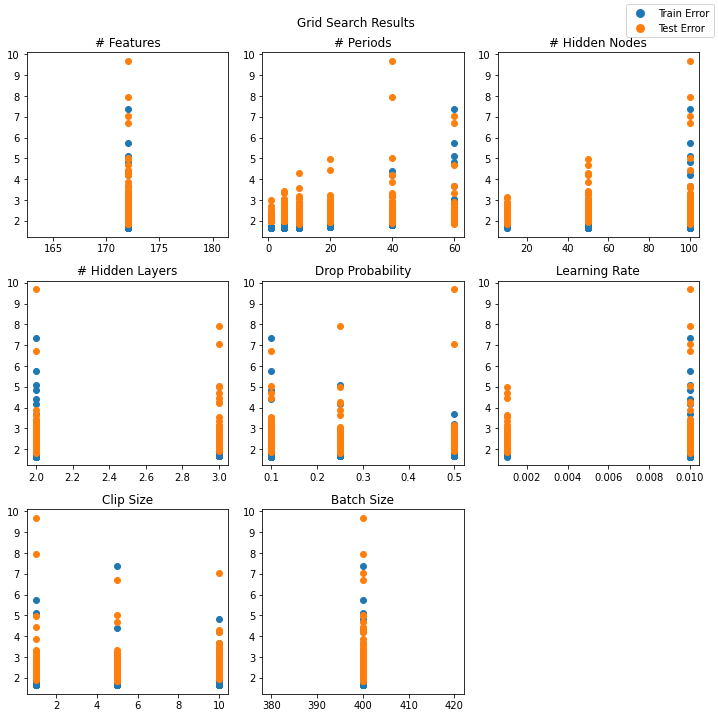

In [12]:
dh.visualizeGridSearch(grid_result)

In [13]:
resultdf = dh.resultDF(grid_result)

In [14]:
sorted_results = resultdf.sort_values(by=['Test Error'])
sorted_results

,Train Error,Test Error,# Features,# Periods,# Hidden Nodes,# Hidden Layers,Drop Probability,Learning Rate,Clip Size,Batch Size
362,1.684997,1.831663,172.0,10.0,10.0,2.0,0.25,0.010,5.0,400.0
233,1.999960,1.864877,172.0,60.0,100.0,2.0,0.10,0.001,5.0,400.0
124,2.681187,1.909742,172.0,40.0,100.0,2.0,0.10,0.010,1.0,400.0
27,1.736413,1.925348,172.0,20.0,50.0,3.0,0.10,0.001,1.0,400.0
197,2.540757,1.928685,172.0,60.0,100.0,2.0,0.50,0.010,1.0,400.0
...,...,...,...,...,...,...,...,...,...,...
358,2.821501,5.037585,172.0,40.0,100.0,3.0,0.10,0.010,5.0,400.0
341,7.357758,6.702535,172.0,60.0,100.0,2.0,0.10,0.010,5.0,400.0
647,2.952324,7.049615,172.0,60.0,100.0,3.0,0.50,0.010,10.0,400.0
178,2.032073,7.935163,172.0,40.0,100.0,3.0,0.25,0.010,1.0,400.0


## Fine Grid Search

In [15]:
best_model_id = sorted_results.index[0]

In [16]:
with open(grid_result_dir+str(best_model_id+1)+'.model','rb') as f:
    model = torch.load(f)
model.eval()


StockLSTM(
  (lstm): LSTM(172, 10, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

In [17]:
# Configure search space
n_features = [df.shape[1]]
n_periods = [model.n_periods]
n_hidden = [model.n_hidden]
n_layers = [model.n_layers]
drop_prob = [model.drop_prob]
lr = [model.lr]
clip = [model.clip]
#batch_size = [1,5,10,20,40,60,120,240]
batch_size = [4,20,40,80,240,480,960]
epochs = [10,25,50,100,250,500]

In [21]:
batch_size = [40,80,240,480,960]
epochs = [250,500]

In [22]:
# use fine grid search to optimize hyperparameters
#fine_grid_result = []
dh.finegridSearch(grid_results = fine_grid_result,
              tickr=tickr,
                           n_features=n_features,
                           n_periods=n_periods,
                           n_hidden=n_hidden,
                           n_layers=n_layers,
                           drop_prob=drop_prob,
                           lr=lr,
                           clip=clip,
                           batch_size=batch_size,
                           data=df,
                           epochs=epochs,
                           n_test=n_test,
                           n_steps_out=1,
                          fpath=fine_grid_result_dir,
                           TRAIN_ON_GPU=TRAIN_ON_GPU,
                           TRAIN_ON_MULTI_GPUS=TRAIN_ON_MULTI_GPUS)

Hyper Parameter search across 10 different configurations.
Iteration: 1 |epochs: 250|periods: 10|hidden: 10|layers: 2|drop: 0.25|lr: 0.01|clip: 5
Training complete in 56m 59s
Iteration: 2 |epochs: 250|periods: 10|hidden: 10|layers: 2|drop: 0.25|lr: 0.01|clip: 5
Training complete in 24m 34s
Iteration: 3 |epochs: 250|periods: 10|hidden: 10|layers: 2|drop: 0.25|lr: 0.01|clip: 5
Training complete in 8m 30s
Iteration: 4 |epochs: 250|periods: 10|hidden: 10|layers: 2|drop: 0.25|lr: 0.01|clip: 5
Training complete in 4m 46s
Iteration: 5 |epochs: 250|periods: 10|hidden: 10|layers: 2|drop: 0.25|lr: 0.01|clip: 5
Training complete in 2m 43s
Iteration: 6 |epochs: 500|periods: 10|hidden: 10|layers: 2|drop: 0.25|lr: 0.01|clip: 5
Training complete in 102m 0s
Iteration: 7 |epochs: 500|periods: 10|hidden: 10|layers: 2|drop: 0.25|lr: 0.01|clip: 5
Training complete in 49m 34s
Iteration: 8 |epochs: 500|periods: 10|hidden: 10|layers: 2|drop: 0.25|lr: 0.01|clip: 5
Training complete in 15m 32s
Iteration: 9 |ep

In [23]:
with open(model_dir+tickr+'fine_grid_search_result.bin','wb') as f:
    pickle.dump(fine_grid_result,f)

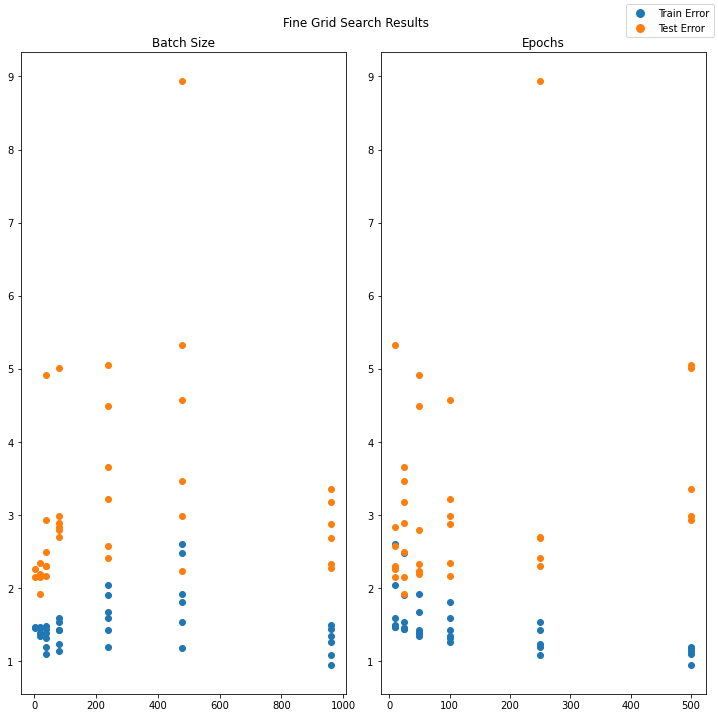

In [24]:
dh.visualizeFineGridSearch(fine_grid_result)

In [25]:
resultdf = dh.resultDFFine(fine_grid_result)

In [26]:
sorted_results = resultdf.sort_values(by=['Test Error'])
sorted_results

,Train Error,Test Error,# Features,# Periods,# Hidden Nodes,# Hidden Layers,Drop Probability,Learning Rate,Clip Size,Batch Size,Epochs
8,1.449335,1.921956,172.0,10.0,10.0,2.0,0.25,0.01,5.0,20.0,25.0
7,1.452167,2.154719,172.0,10.0,10.0,2.0,0.25,0.01,5.0,4.0,25.0
1,1.465164,2.156296,172.0,10.0,10.0,2.0,0.25,0.01,5.0,20.0,10.0
21,1.321737,2.164504,172.0,10.0,10.0,2.0,0.25,0.01,5.0,40.0,100.0
14,1.379452,2.187119,172.0,10.0,10.0,2.0,0.25,0.01,5.0,20.0,50.0
18,1.914672,2.233319,172.0,10.0,10.0,2.0,0.25,0.01,5.0,480.0,50.0
0,1.465032,2.266957,172.0,10.0,10.0,2.0,0.25,0.01,5.0,4.0,10.0
6,1.492806,2.268922,172.0,10.0,10.0,2.0,0.25,0.01,5.0,960.0,10.0
2,1.478111,2.296944,172.0,10.0,10.0,2.0,0.25,0.01,5.0,40.0,10.0
26,1.194446,2.308787,172.0,10.0,10.0,2.0,0.25,0.01,5.0,40.0,250.0


## Evaluate Final Model

In [27]:
best_model_id = sorted_results.index[0]
with open(fine_grid_result_dir+str(best_model_id+1)+'.model','rb') as f:
    model = torch.load(f)
model.eval()

StockLSTM(
  (lstm): LSTM(172, 10, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

Training RMSE: 1.3010467706476547
Test RMSE: 0.6130660310134411
Training MAE: 0.5712954371943273
Test MAE: 0.48512640933716955
Training - Above Error: $0.58 (52.68%) Below Error: $-0.56 (47.32%)
Test - Above Error: $0.54 (43.24%) Below Error: $-0.45 (56.76%)


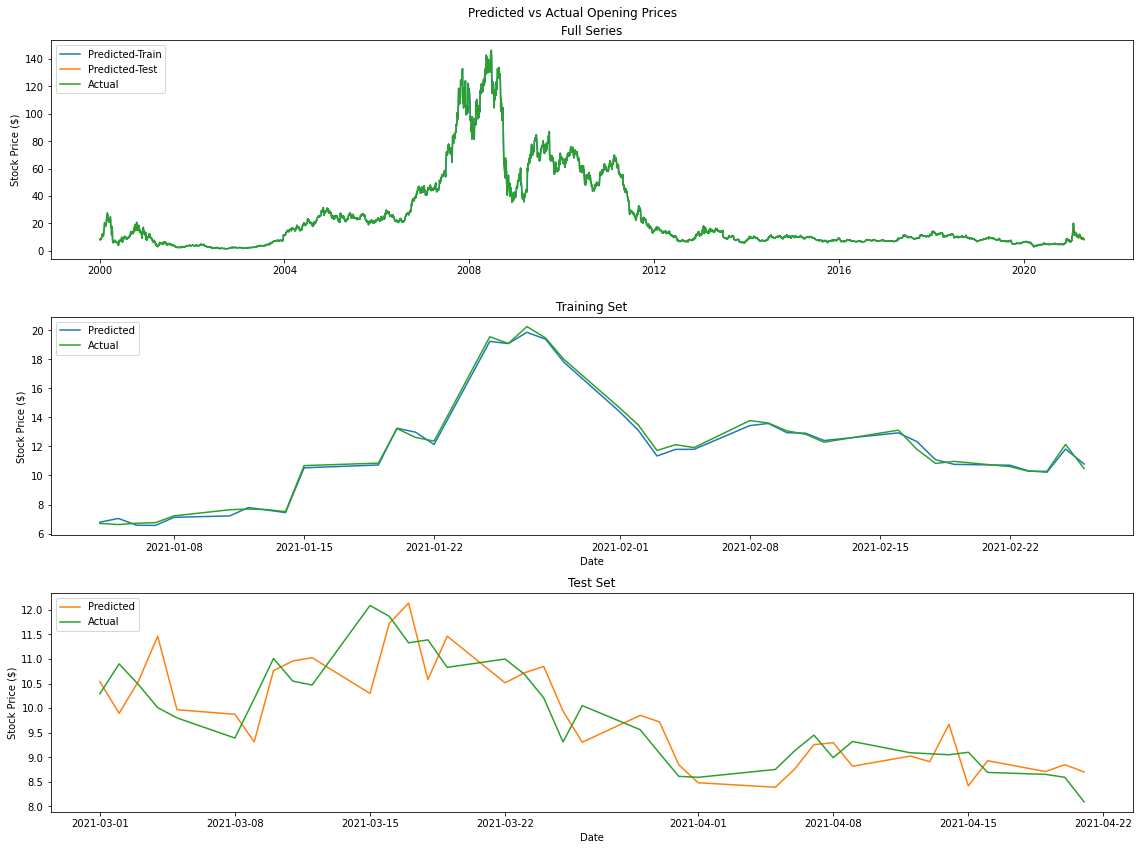

In [28]:
preds = dh.evaluateModel(model=model,
             input_data=df,
             output_data=output_data[:-1],
             scaler=scaler,
             n_steps_in=model.n_periods,
             n_steps_out=1,
             n_test=n_test)

In [29]:
preds.tail()

,Open,Raw_Predictions,Prediction_Type,Predicted
Date,,,,
2021-04-15,9.10,-0.018857,Test,8.415737
2021-04-16,8.69,0.001953,Test,8.928401
2021-04-19,8.65,0.022938,Test,8.706975
2021-04-20,8.59,0.012634,Test,8.848413
2021-04-21,8.09,-0.027899,Test,8.698522


In [30]:
with open(pred_dir+tickr+'_pred.bin','wb') as f:
    pickle.dump(preds,f)

In [31]:
with open(final_model_dir+tickr+'_model.model','wb') as f:
    torch.save(model,f)